In [3]:
# Importing packages
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
import itertools
from ipywidgets import Layout
import seaborn as sns
import math

import time
from scipy import linalg
import scipy.optimize as optimize
import sympy as sm

from tkinter import *
import tkinter as tk

from data_gen import gen_df 



In this project, we want to try to estimate the ratings of movies. That is, we well calculate the utility of a movie, given genres, duration, awards and so forth, and we will try to calculate the IMDB ratings for each movie, based on this utility. Finally, we will then minimize the distance between our estimated ratings and the actual ratings. 

Our utility function is given by: 
$$ U_i = \sum_{k=1}^{23}(\alpha_k G_{ik}) + \sum_{k=1920}^{2010} (\beta_k D_{ik}) + \gamma N_i + \delta W_i + \rho_1 L_i + \rho_2 L_i^2 $$. 

Based on this utility function, we will estimate the ratings of each movies,
$$ R_i^{model} = \frac{\exp(\omega x_i)}{1 + \exp(\omega x_i)} $$ 

where, 
$$ x_i = \big[G_1, G_2, ..., G_n, D_{1920}, D_{1930}, ..., D_{2010}, N_i, W_i, L_i, L_i^2 \big] $$
$$ \omega = \big[\alpha_1, \alpha_2, ..., \alpha_{23}, \beta_{1920}, \beta_{1930}, \beta_{2010}, \gamma, \delta, \rho_1, \rho_2  \big] $$

We then use optimize methods to solve the following: 

$$ \min_{\omega} \Big\{ \sum_{i=1}^{n} \left( R_i^{model} - R_i^{data} \right)^2 \Big\} $$


In [4]:
def df_s(keep_top=None):

    filename = 'imdb.csv'

    df = gen_df(filename)

    decade_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

    # Decade dummies
    for i in decade_list:
        df[f'decade_{i}'] = 0
        df.loc[(df['decade'] == f'{i}s'),f'decade_{i}'] = 1

    df = df.loc[(df['ratingCount']>=5000)]
    df.drop(columns=['Adult','GameShow','News','RealityTV','TalkShow'], inplace=True)

    if keep_top != None:
        df = df.sort_values('imdbRating', ascending=False)
        df = df.iloc[:keep_top]

    df_X = df.copy()
    df_Y = pd.DataFrame(df['imdbRating'].copy())
    df_Y.rename(columns = {'imdbRating':'rat_data'}, inplace=True)

    drops = ['index', 'tid', 'title', 'imdbRating', 'ratingCount', 'year', 
             'nrOfGenre', 'nrOfPhotos', 'nrOfNewsArticles',  'nrOfUserReviews', 'decade']

    for i in drops:
        df_X.drop(columns=[i], inplace=True)

    # Rearrange columns
    df_X = df_X.reindex(['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                              'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                              'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                              'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                              'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                              'nrOfNominations','nrOfWins','duration'], axis=1)
    
    return df_X, df_Y

Iteration 1: Function value = 16011.77
Iteration 2: Function value = 16011.77
Iteration 3: Function value = 16011.77
Iteration 4: Function value = 16011.77
Iteration 5: Function value = 16011.77
...
Iteration 1000: Function value = 6299.75
Iteration 2000: Function value = 3959.90
Iteration 3000: Function value = 1787.75
Iteration 4000: Function value = 1383.11
Iteration 5000: Function value = 1345.15
Iteration 6000: Function value = 1298.39
Iteration 7000: Function value = 1212.60
Iteration 8000: Function value = 1190.26
Iteration 9000: Function value = 1120.97
Iteration 10000: Function value = 1116.77
Iteration 11000: Function value = 1037.89
Iteration 12000: Function value = 1037.14
Iteration 13000: Function value = 1034.90
Iteration 14000: Function value = 986.67
Iteration 15000: Function value = 939.69
Iteration 16000: Function value = 939.67
Iteration 17000: Function value = 938.27
Iteration 18000: Function value = 912.72
Iteration 19000: Function value = 895.34
Optimization termi

AttributeError: 'AxesSubplot' object has no attribute 'add_title'

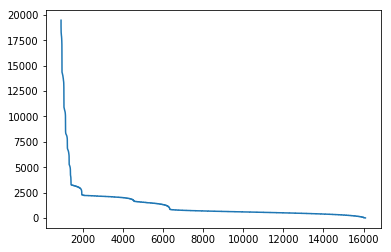

In [43]:
def optimizer(keep_top=None):
    global fs
    global evals
    global x0
    
    def sqr_diff_sum(df_X,pars):
        util = df_X@pars
        df_Y['rat_model'] = 10*np.exp(util)/(1+np.exp(util))
        df_Y['sqr_diff'] = (df_Y['rat_model']-df_Y['rat_data'])**2
        return df_Y['sqr_diff'].sum()

    # Scipy minimize
    def zeros(n): 
        list = [0] * n
        return list 

    def collect(x):
        global fs
        global evals
        global x0

        if evals == 0:
            fs = []
            fs.append(obj_fun(x0))
            
        elif evals < 5:
            print(f'Iteration {evals}: Function value = {obj_fun(x):.2f}')
            time.sleep(.5)
        elif evals == 5:
            print(f'Iteration {evals}: Function value = {obj_fun(x):.2f}')
            print('...')
        elif evals%1000 == 0:
            print(f'Iteration {evals}: Function value = {obj_fun(x):.2f}')
        
        fs.append(obj_fun(x))
        evals += 1
        
    df_X, df_Y = df_s(keep_top)
    x0 = zeros(36)
    evals = 0
    
    obj_fun = lambda x: sqr_diff_sum(df_X,x)
        
    result = optimize.minimize(obj_fun,x0,
                               method="Nelder-Mead",
                               options={"disp":True, "maxiter": 1000000}, # display the results
                               callback=collect
                               ) 
    
    # Progress figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(fs,range(evals+1))
    """
    ax.title('Progress')
    ax.add_xlabel('Iterations')
    ax.add_ylabel('Function value')
    """
    plt.show()
    
    return result

result = optimizer(keep_top=2000)

result.x

variables = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                          'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                          'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                          'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                          'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                          'nrOfNominations','nrOfWins','duration']

results = dict()

for j,i in enumerate(variables):
    results[i] = result.x[j]

In [27]:
filename = 'imdb.csv'

df = gen_df(filename)

decade_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

# Decade dummies
for i in decade_list:
    df[f'decade_{i}'] = 0
    df.loc[(df['decade'] == f'{i}s'),f'decade_{i}'] = 1

df = df.loc[(df['ratingCount']>=5000)]
df.drop(columns=['Adult','GameShow','News','RealityTV','TalkShow'], inplace=True)

df = df.sort_values('imdbRating', ascending=False)
df = df.iloc[:2000]

def opt_diff(res, df):
    
        df['util'] = 0
        
        for key,value in res.items():
            df['util'] += df[key]*value
        
        df['rat_model'] = 10*np.exp(df['util'])/(1+np.exp(df['util']))
        
        df['Diff'] = abs(df['imdbRating']-df['rat_model'])
        
        return df
    
df = opt_diff(results,df)

df = df.sort_values(['year', 'Diff'], ascending=False)
df.reindex(['title','year','imdbRating','rat_model','Diff'], axis=1).sort_values('Diff')
df.Diff.describe()
    

NameError: name 'results' is not defined